In [139]:
import os
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import nltk
# from wordcloud import WordCloud
from nrclex import NRCLex

sns.set(style='darkgrid')

# Daily Post Frequency

Note: DataFrame is NOT already sorted by date!

In [2]:
df = pd.read_csv('raw_data_2017/01Jan2017.csv').drop(['Unnamed: 0'], axis=1)
for year in range(2017, 2021):
    for file in os.listdir(f'raw_data_{year}'):
        if file[-3:] == 'csv':
            df_new = pd.read_csv(f'raw_data_{year}/{file}').drop(['Unnamed: 0'], axis=1)
            df_new.time = df_new.time.apply(lambda x: file[:-4])
            df = pd.concat([df, df_new]).reset_index(drop=True)
df.head()

,text,time,score
0,"I don't know how many of you read it, but a fe...",01Jan2017,6
1,[deleted],01Jan2017,10
2,The reason that it occurred to me that I may h...,01Jan2017,1
3,Sometimes I don't really feel like a participa...,01Jan2017,5
4,[deleted],01Jan2017,3


In [3]:
# reformat dates
df.time = df.time.apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [4]:
# sort by date
df = df.sort_values('time')

In [60]:
# calculate frequencies for each date
sorted_dates = df.time.value_counts().sort_index()

freq = pd.DataFrame(sorted_dates).reset_index().rename(columns={'time': 'num_posts', 'index': 'date'})

# calculate SMOOTHED frequencies 
smoothed_freq = pd.DataFrame(sorted_dates).rolling(30).mean().reset_index().rename(columns={'time': 'num_posts',
                                                                                            'index': 'date'})

In [7]:
series = alt.Chart(freq).mark_line(opacity=0.3,
                                  ).encode(x='date', y='num_posts'
                                  ).properties(title='Frequency of r/MentalHealth Posts'
                                  ).interactive(bind_y=False)

smoothed = alt.Chart(smoothed_freq.reset_index()).mark_line(
                                                           ).encode(x='date', y='num_posts', tooltip=['date', 'num_posts']
                                                           ).properties(title='Frequency of r/MentalHealth Posts'
                                                           ).interactive(bind_y=False)

chart = (series + smoothed).properties(width=800, height=300)
chart.save('figures/post_freq.html')

### Normalized by Subscribers 

In [120]:
trend = pd.read_csv('subscriber_count.csv')
trend['subscribers'] = trend['subscribers'].interpolate()
trend['date'] = trend['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M').replace(hour=0, minute=0))

overlap = pd.DataFrame()
dates = freq[freq['date'].isin(trend.date)]['date']
overlap['date'] = dates
overlap_subs = trend[trend['date'].isin(dates)].reset_index().drop(['index'], axis=1)

overlap['detrended'] = freq['num_posts'] / overlap_subs['subscribers']

In [138]:
series = alt.Chart(overlap).mark_line(opacity=0.3,
                                  ).encode(x='date:T', y='detrended:Q'
                                  ).properties(title='Frequency of r/MentalHealth Posts, Normalized by Subscribers'
                                  ).interactive(bind_y=False)
series

overlap['smoothed'] = overlap['detrended'].rolling(30).mean()
smoothed = alt.Chart(overlap).mark_line(
                                         ).encode(x='date:T', y='smoothed:Q', tooltip=['date', 'smoothed']
                                         ).properties(title='Frequency of r/MentalHealth Posts, Normalized by Subscribers'
                                         ).interactive(bind_y=False)


chart = (series + smoothed).properties(width=800, height=300)
chart.save('figures/post_freq_normalized.html')

# Scores

In [346]:
scores = df[['time', 'score']]
scores['score'] = scores['score'].apply(lambda x: np.log(x + 1))
groups = scores.groupby([scores.time.dt.year, scores.time.dt.month])

all_scores = pd.DataFrame(columns=['time', 'score'])
for i, group in enumerate(groups):
    if i == 0:
        continue
    all_scores = all_scores.append(group[1])
all_scores

<ipython-input-346-ee179ffb0571>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores['score'] = scores['score'].apply(lambda x: np.log(x + 1))


,time,score
0,2017-01-01,1.945910
286,2017-01-01,0.000000
266,2017-01-01,1.098612
265,2017-01-01,1.386294
264,2017-01-01,0.693147
...,...,...
108222,2020-12-30,0.693147
108221,2020-12-30,0.693147
108220,2020-12-30,0.693147
108218,2020-12-30,0.693147


## By Month

In [443]:
def clean_time(x):
    x = datetime.strftime(x, '%Y-%m')
    return (int(x[:4]) - 2017) * 12 + int(x[5:7])

In [454]:
scores = df[['time', 'score']]
scores['score'] = scores['score'].apply(lambda x: np.log(x + 1))
groups = scores.groupby([scores.time.dt.year, scores.time.dt.month])

all_scores = pd.DataFrame(columns=['time', 'score'])
for i, group in enumerate(groups):
    if i == 0:
        continue
    all_scores = all_scores.append(group[1])
all_scores['time'] = all_scores['time'].apply(clean_time)
all_scores

<ipython-input-454-aa67099027b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores['score'] = scores['score'].apply(lambda x: np.log(x + 1))


,time,score
0,1,1.945910
286,1,0.000000
266,1,1.098612
265,1,1.386294
264,1,0.693147
...,...,...
108222,48,0.693147
108221,48,0.693147
108220,48,0.693147
108218,48,0.693147


In [459]:
slider = alt.binding_range(name='date: ', min=1, 
                                          max=48,
                                          step=1)

select_year = alt.selection_single(name='date', fields=['time'],
                                   bind=slider, init={'time': 1})

scores_chart = alt.Chart(all_scores).add_selection(
    select_year
).transform_filter(
    select_year
).properties(
    width=700, height=300
).encode(
    x=alt.X('score:Q', bin=alt.Bin(extent=[0, 6], step=0.25)),
    y=alt.Y('count()')
).mark_bar().properties(title='Log-Score Distribution')

scores_chart.save('figures/score_dist.html')

## By Year

In [460]:
def clean_time_year(x):
    x = datetime.strftime(x, '%Y-%m')
    return int(x[:4])

In [461]:
scores = df[['time', 'score']]
scores['score'] = scores['score'].apply(lambda x: np.log(x + 1))
groups = scores.groupby([scores.time.dt.year])

all_scores = pd.DataFrame(columns=['time', 'score'])
for i, group in enumerate(groups):
    if i == 0:
        continue
    all_scores = all_scores.append(group[1])
all_scores['time'] = all_scores['time'].apply(clean_time_year)
all_scores

<ipython-input-461-a27d5e2a73cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores['score'] = scores['score'].apply(lambda x: np.log(x + 1))


,time,score
0,2017,1.945910
286,2017,0.000000
266,2017,1.098612
265,2017,1.386294
264,2017,0.693147
...,...,...
108222,2020,0.693147
108221,2020,0.693147
108220,2020,0.693147
108218,2020,0.693147


In [462]:
slider = alt.binding_range(name='date: ', min=2017, 
                                          max=2020,
                                          step=1)

select_year = alt.selection_single(name='date', fields=['time'],
                                   bind=slider, init={'time': 2017})

scores_chart = alt.Chart(all_scores).add_selection(
    select_year
).transform_filter(
    select_year
).properties(
    width=700, height=300
).encode(
    x=alt.X('score:Q', bin=alt.Bin(extent=[0, 6], step=0.25)),
    y=alt.Y('count()', scale=alt.Scale(type='log'))
).mark_bar().properties(title='Log-Score Distribution')

scores_chart.save('figures/score_dist_year.html')

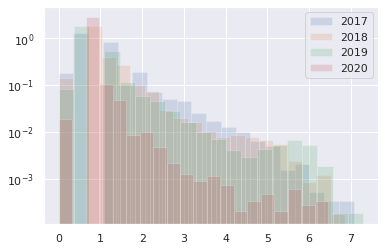

In [464]:
for i, group in enumerate(groups):
    if i == 0: 
        continue
    plt.hist(group[1]['score'], alpha=0.2, density=True, bins=20, label=group[0])
    plt.yscale('log')
    plt.legend()

# Emotion Content
as measured by NRCLex.

**ONLY RUN THESE CELLS ONCE ============================================================================================**

In [127]:
#more EDA using emotion data package NRCLex
#question: should i standardize each post by number of tokens and then standardize whole weeks count by number of posts?
features = {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5,
            'surprise': 6, 'trust': 7, 'negative': 8, 'positive': 9}

dates = sorted([datetime.strftime(datetime.strptime(file[:-4], '%d%b%Y'), '%Y-%m-%d') \
                for year in range(2017, 2021) \
                for file in os.listdir(f'raw_data_{year}') \
                if file[-3:] == 'csv'])

In [128]:
data = []
df_text = df[df['text'] != '[deleted]']

for date in dates:
    data.append(df_text[df_text['time'] == datetime.strptime(date, '%Y-%m-%d')])

In [129]:
emotion_by_day = np.zeros((len(data), 10))
for i in tqdm(range(0, len(data))):
    texts = data[i]['text'].values
    num_tokens_per_day = 0
    for j in texts:
        try:
            tokens = nltk.word_tokenize(j.lower())
            num_tokens_per_day += len(tokens)
            emotion = NRCLex(j.lower())
            emotion_dict = emotion.raw_emotion_scores
            for key in emotion_dict:
                col = features[key]
                count = emotion_dict[key]
                emotion_by_day[i, col] += count
        except:
            # skip over non-text posts
            continue
        
    #normalize frequency of each emotion (over the 1 week period) by number of tokens (over the 1 week period)
    emotion_by_day[i, :] = (emotion_by_day[i, :] / num_tokens_per_day) * 100
            
emotion_scores = pd.DataFrame(emotion_by_day, 
                              columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                                         'sadness', 'surprise', 'trust', 'negative', 'positive'], 
                              index = dates)
emotion_scores.head()

100%|██████████| 872/872 [08:07<00:00,  1.79it/s]


,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
2016-12-31,1.835547,2.238472,1.193852,2.313088,1.417699,2.208626,0.910312,2.029548,3.790479,3.521862
2017-01-01,1.835547,2.238472,1.193852,2.313088,1.417699,2.208626,0.910312,2.029548,3.790479,3.521862
2017-01-02,1.708164,1.939780,1.071222,2.388535,1.331789,2.547771,0.897510,2.012160,4.067748,3.126809
2017-01-03,1.708164,1.939780,1.071222,2.388535,1.331789,2.547771,0.897510,2.012160,4.067748,3.126809
2017-01-04,1.574550,2.313625,0.851542,1.911954,1.349614,2.056555,0.723008,2.313625,3.631105,3.213368


In [154]:
# make sure date is in the right format
emotion_scores_new = emotion_scores.reset_index().rename({'index': 'date'}, axis=1)
emotion_scores_new.date = emotion_scores_new.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
emotion_scores_new.to_json('clean_data/emotion_scores.json')

**=======================================================================================================================**

In [188]:
# compute rolling mean to reduce noise
emotion_scores = pd.read_json('clean_data/emotion_scores.json')
emotion_scores = pd.concat([emotion_scores.date, emotion_scores.rolling(7).mean()], axis=1).rename({0: 'date'}, axis=1)
emotion_scores = emotion_scores.melt('date', var_name='emotion', value_name='score')
# melt emotions for easier plotting if read in wide form
emotion_scores.to_json('clean_data/emotion_scores_long.json')

In [189]:
emotion_scores = pd.read_json('clean_data/emotion_scores_long.json')
emotion_scores.date

0      2016-12-31
1      2017-01-01
2      2017-01-02
3      2017-01-03
4      2017-01-04
          ...    
8715   2020-12-22
8716   2020-12-24
8717   2020-12-26
8718   2020-12-28
8719   2020-12-30
Name: date, Length: 8720, dtype: datetime64[ns]

In [191]:
alt.data_transformers.enable('json')

selection = alt.selection_multi(fields=['emotion'], bind='legend')
series = alt.Chart(emotion_scores).mark_line(
                                  ).encode(x='date:T', y='score:Q', color='emotion:N',
                                           opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
                                           tooltip=['score']
                                  ).properties(title='Average Emotional Tokens per Post', width=800, height=300
                                  ).add_selection(selection
                                  ).interactive(bind_y=False)

alt.data_transformers.enable('default')
series.save('figures/emotion_freq.html')

In [ ]:
# # generating word clouds for each of the weeks
# for i in range(0,24):
#     titles = data[i]['title']
#     texts = data[i]['text']
#     list_of_words = ''
#     for j in titles:
#         tokens = nltk.word_tokenize(j.lower())
#         list_of_words += " ".join(tokens)+" "
#     for k in texts:
#         tokens = nltk.word_tokenize(k.lower())
#         list_of_words += " ".join(tokens)+" "
#     wc = WordCloud().generate(list_of_words)   
#     plt.imshow(wc)
#     plt.show()